# Table of Contents: <a class="anchor" id="contents"></a> 

* [Importing and cleaning data](#import)
* [Function Definitions](#funcdef)
    * [Recursive Feature Elimination (RFE) with Features and Target](#rfe)
    * [Cross Validated ROC Chart](#cvroc)
* [Target: HNHC](#hnhc)
    * [Logistic Regression RFE - HNHC](#lrhnhc)
    * [Decision Tree Classifier RFE - HNHC](#dtchnhc)
    * [XGBoost Classifier RFE](#xgbchnhc)
* [Target: HNHC without 'los'](#hnhcwolos)
    * [Logistic Regression RFE - HNHC](#lrhnhcwolos)
    * [Decision Tree Classifier RFE - HNHC](#dtchnhcwolos)
    * [XGBoost Classifier RFE](#xgbchnhcwolos)
* [Target: IBD_READM](#ibd)
    * [Logistic Regression RFE - HNHC](#lribd)
    * [Decision Tree Classifier RFE - HNHC](#dtcibd)
    * [XGBoost Classifier RFE](#xgbcibd)
* [Target: IBD_READM without 'los'](#ibdwolos)
    * [Logistic Regression RFE - HNHC](#lribdwolos)
    * [Decision Tree Classifier RFE - HNHC](#dtcibdwolos)
    * [XGBoost Classifier RFE](#xgbcibdwolos)

## Importing and cleaning data <a class="anchor" id="import"></a>

[Return to Table of Contents](#contents)

In [1]:
# Import dependencies
from sklearn import tree
from sklearn import metrics, model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
from numpy import interp
import os
import warnings
import timeit
import dask.dataframe as dd
from IPython.display import display 
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
# Read in the data as a dataframe.
df = pd.read_csv('data/NRD 2013 (machine learning).csv')
df.head()

3              3               0   
3              1            1              1               1   
4              5            1              5               1   

   ibd_index_six_months  ibd_index_death  ibd_index_after_june  \
0                   1.0              NaN                   NaN   
1                   NaN              NaN                   NaN   
2                   NaN              NaN                   NaN   
3                   1.0              NaN                   NaN   
4                   1.0              NaN                   NaN   

   ibd_index_flag_exclude  ibd_min_dmonth  ibd_total_los  dmonth_dead  \
0                     NaN             3.0           21.0            0   
1                     NaN             NaN           21.0            0   
2                     NaN             NaN           21.0            0   
3                     NaN             6.0            4.0            0   
4                     NaN             5.0           34.0            0   

   dmonth_dead_fu  ibd_fu_v1  ibd_fu_v2  ibd_alive_fu  before_ibd_index_adm  \
0               0         10         10            10                   NaN   
1               0          0         10            10                   NaN   
2               0          0         10            10                   NaN   
3               0          7          7             7                   NaN   
4               0          8          8             8                   NaN   

   total_before_ibd_index  before_ibd_index  ibdtotaladm_from_index  \
0                       0                 0                       3   
1                       0                 0                       3   
2                       0                 0                       3   
3                       0                 0                       1   
4                       0                 0                       5   

   ibdtotlos_alive_fu  ibdtotadm_alive_fu  ibd_total_charges  \
0            2.100000            0.300000          52107.672   
1                 NaN                 NaN          52107.672   
2                 NaN                 NaN          52107.672   
3            0.571429            0.142857          10820.521   
4            4.250000            0.625000          41874.746   

   ibdtotcharges_alive_fu  age_group  young_quintile  young_quintile_flag  \
0               5210.7671          2               0                  0.0   
1                     NaN          2               0                  0.0   
2                     NaN          2               0                  0.0   
3               1545.7887          1               0                  0.0   
4               5234.3433          2               0                  0.0   

   sum_young  middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
0      85151                0                   0.0      114990             1   
1      85151                0                   0.0      114990             1   
2      85151                0                   0.0      114990             1   
3      85151                1                   1.0      114990             0   
4      85151                0                   0.0      114990             1   

   old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
0                3.0    79516                 NaN                  NaN   
1                3.0    79516                 NaN                  NaN   
2                3.0    79516                 NaN                  NaN   
3                0.0    79516                 NaN                  2.0   
4                5.0    79516                 NaN                  NaN   

   ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
0               4.0            0.0                         0   
1               NaN            0.0                         0   
2               NaN            0.0                         0   
3               NaN            0.0                         1 

In [4]:
# Create a list of the column names and print it out.
variables = df.columns.values

In [3]:
# Look at the ibd_specific_adm column
df['ibd_specific_adm']

0        0
1        0
2        0
3        1
4        1
        ..
94493    1
94494    0
94495    0
94496    0
94497    1
Name: ibd_specific_adm, Length: 94498, dtype: int64

In [5]:
# Make a copy of the dataframe
df_copy = df.copy()
df_copy.head()

3              3               0   
3              1            1              1               1   
4              5            1              5               1   

   ibd_index_six_months  ibd_index_death  ibd_index_after_june  \
0                   1.0              NaN                   NaN   
1                   NaN              NaN                   NaN   
2                   NaN              NaN                   NaN   
3                   1.0              NaN                   NaN   
4                   1.0              NaN                   NaN   

   ibd_index_flag_exclude  ibd_min_dmonth  ibd_total_los  dmonth_dead  \
0                     NaN             3.0           21.0            0   
1                     NaN             NaN           21.0            0   
2                     NaN             NaN           21.0            0   
3                     NaN             6.0            4.0            0   
4                     NaN             5.0           34.0            0   

   dmonth_dead_fu  ibd_fu_v1  ibd_fu_v2  ibd_alive_fu  before_ibd_index_adm  \
0               0         10         10            10                   NaN   
1               0          0         10            10                   NaN   
2               0          0         10            10                   NaN   
3               0          7          7             7                   NaN   
4               0          8          8             8                   NaN   

   total_before_ibd_index  before_ibd_index  ibdtotaladm_from_index  \
0                       0                 0                       3   
1                       0                 0                       3   
2                       0                 0                       3   
3                       0                 0                       1   
4                       0                 0                       5   

   ibdtotlos_alive_fu  ibdtotadm_alive_fu  ibd_total_charges  \
0            2.100000            0.300000          52107.672   
1                 NaN                 NaN          52107.672   
2                 NaN                 NaN          52107.672   
3            0.571429            0.142857          10820.521   
4            4.250000            0.625000          41874.746   

   ibdtotcharges_alive_fu  age_group  young_quintile  young_quintile_flag  \
0               5210.7671          2               0                  0.0   
1                     NaN          2               0                  0.0   
2                     NaN          2               0                  0.0   
3               1545.7887          1               0                  0.0   
4               5234.3433          2               0                  0.0   

   sum_young  middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
0      85151                0                   0.0      114990             1   
1      85151                0                   0.0      114990             1   
2      85151                0                   0.0      114990             1   
3      85151                1                   1.0      114990             0   
4      85151                0                   0.0      114990             1   

   old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
0                3.0    79516                 NaN                  NaN   
1                3.0    79516                 NaN                  NaN   
2                3.0    79516                 NaN                  NaN   
3                0.0    79516                 NaN                  2.0   
4                5.0    79516                 NaN                  NaN   

   ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
0               4.0            0.0                         0   
1               NaN            0.0                         0   
2               NaN            0.0                         0   
3               NaN            0.0                         1 

In [6]:
# Check the back end of the data
df_copy.tail()

11   

       ibd_alive_fu  before_ibd_index_adm  total_before_ibd_index  \
94493             7                   NaN                       0   
94494             7                   NaN                       0   
94495             7                   NaN                       0   
94496            11                   NaN                       0   
94497            11                   NaN                       0   

       before_ibd_index  ibdtotaladm_from_index  ibdtotlos_alive_fu  \
94493                 0                       3            2.571429   
94494                 0                       3                 NaN   
94495                 0                       3                 NaN   
94496                 0                       1            0.181818   
94497                 0                       1            0.363636   

       ibdtotadm_alive_fu  ibd_total_charges  ibdtotcharges_alive_fu  \
94493            0.428571         58356.2970              8336.61430   
94494                 NaN         58356.2970                     NaN   
94495                 NaN         58356.2970                     NaN   
94496            0.090909         15479.2880              1407.20800   
94497            0.090909          5843.7397               531.24908   

       age_group  young_quintile  young_quintile_flag  sum_young  \
94493          1               0                  0.0      85151   
94494          1               0                  0.0      85151   
94495          1               0                  0.0      85151   
94496          1               0                  0.0      85151   
94497          2               0                  0.0      85151   

       middle_quintile  middle_quintile_flag  sum_middle  old_quintile  \
94493                1                   3.0      114990             0   
94494                1                   3.0      114990             0   
94495                1                   3.0      114990             0   
94496                1                   1.0      114990             0   
94497                0                   0.0      114990             1   

       old_quintile_flag  sum_old  ibd_young_quartile  ibd_middle_quartile  \
94493                0.0    79516                 NaN                  4.0   
94494                0.0    79516                 NaN                  NaN   
94495                0.0    79516                 NaN                  NaN   
94496                0.0    79516                 NaN                  1.0   
94497                1.0    79516                 NaN                  NaN   

       ibd_old_quartile  tot_ibd_death  gi_or_hepatic_proc_index  \
94493               NaN            0.0                         1   
94494               NaN            0.0                         1   
94495               NaN            0.0                         0   
94496               NaN            0.0                         0   
94497               2.0            0.0                         0   

       blood_transfusion  parenteral_or_enteral_index  ibd_procedures  \
94493                  1                            0               1   
94494                  0                            0               1   
94495                  0                            0               0   
94496                  0                            0               0   
94497                  0                            0               0   

       tot_gi_or_hepatic_proc  max_nrd_daystoevent  ibd_max_daystoevent  \
94493                     1.0              14600.0                14600   
94494                     1.0                  NaN                14600   
94495                     1.0                  NaN                14600   
94496                     0.0              17978.0                17978   
94497                     0.0              22167.0                22167   

       ibd_readm  ibd_tot_readm  ibd_net_readm  ibd_colostomy_adm  \
94493          0           

In [7]:
# Check the data 
# Looks like the ibd_readm variables contains "NA" values
df_copy[['nrd_visitlink','ibd_index_hosp', 'dx1', 'new_mi_adm', 'ibd_readm']].head()

nrd_visitlink  ibd_index_hosp    dx1  new_mi_adm  ibd_readm
0        00017u               1  00845           0          0
1        00017u               0   0389           0          1
2        00017u               0  03842           0          1
3        0004o5               1   5559           0          0
4        000dbz               1   5559           0          0

In [8]:
# Recoding the ibd_readm outcome variable
readm_set = set()
for index, row in df_copy[['nrd_visitlink','ibd_readm']].iterrows():
    if row[1] == 1:
        readm_set.add(row[0])
        
readm_list = list(readm_set)

df_copy.loc[df_copy.nrd_visitlink.isin(readm_list), 'ibd_readm'] = '1'
df_copy[['nrd_visitlink','ibd_index_hosp', 'ibd_readm']].head(15)

nrd_visitlink  ibd_index_hosp ibd_readm
0         00017u               1         1
1         00017u               0         1
2         00017u               0         1
3         0004o5               1         0
4         000dbz               1         1
5         000dbz               0         1
6         000dbz               0         1
7         000dbz               0         1
8         000dbz               0         1
9         000mgu               1         0
10        0018do               1         0
11        001nun               1         1
12        001nun               0         1
13        001nun               0         1
14        001nun               0         1

In [9]:
df_copy[['nrd_visitlink', 'pay1', 'ibd_index_hosp', 'ibd_readm']].head(15)

nrd_visitlink  pay1  ibd_index_hosp ibd_readm
0         00017u   1.0               1         1
1         00017u   1.0               0         1
2         00017u   1.0               0         1
3         0004o5   3.0               1         0
4         000dbz   1.0               1         1
5         000dbz   1.0               0         1
6         000dbz   1.0               0         1
7         000dbz   1.0               0         1
8         000dbz   1.0               0         1
9         000mgu   3.0               1         0
10        0018do   2.0               1         0
11        001nun   2.0               1         1
12        001nun   2.0               0         1
13        001nun   2.0               0         1
14        001nun   2.0               0         1

In [10]:
# Number of index hospitalizations
index_hosp_counts = df_copy['ibd_index_hosp'].value_counts()
index_hosp_counts

1    47402
0    47096
Name: ibd_index_hosp, dtype: int64

In [11]:
# Number of readmissions within six months
readm_counts = df_copy['ibd_readm'].value_counts()
readm_counts

1    64373
0    30125
Name: ibd_readm, dtype: int64

In [12]:
# Filter the data so that only patients with an index hospitalizations are in a DataFrame
readm_data_df = df_copy.loc[df_copy["ibd_index_hosp"] == 1, :]

# Check to ensure the filter worked correctly
readm_data_df["ibd_index_hosp"].count()

47402

In [13]:
# Creating deciles by length of follow-up normalized by number of hospitalizations 
readm_data_df['ibd_deciles'] = pd.qcut(readm_data_df['ibdtotlos_alive_fu'], 10, labels=np.arange(10, 0, -1))

readm_data_df.head(15)

0   
19                     0                     0                  0   
22                     0                     0                  0   
23                     0                     0                  0   
30                     0                     0                  0   
31                     0                     0                  0   
32                     0                     0                  0   
33                     0                     0                  0   
38                     0                     0                  0   
39                     0                     0                  0   

    new_pyelonephritis_adm  new_osteo_adm  new_septicemia_adm  new_cdiff_adm  \
0                        0              0                   0              1   
3                        0              0                   0              0   
4                        0              0                   0              0   
9                        0              0                   0              0   
10                       0              0                   0              0   
11                       0              0                   0              0   
19                       0              0                   0              0   
22                       0              0                   1              0   
23                       0              0                   0              0   
30                       0              1                   1              0   
31                       0              0                   0              0   
32                       0              0                   0              0   
33                       0              0                   0              0   
38                       0              0                   0              0   
39                       0              0                   0              0   

    new_tb_adm  new_atypicalmyco_adm  new_fungal_adm  new_listeriosis_adm  \
0            0                     0               0                    0   
3            0                     0               0                    0   
4            0                     0               0                    0   
9            0                     0               0                    0   
10           0                     0               0                    0   
11           0                     0               0                    0   
19           0                     0               0                    0   
22           0                     0               0                    0   
23           0                     0               0                    0   
30           0                     0               0                    0   
31           0                     0               0                    0   
32           0                     0               0                    0   
33           0                     0               0                    0   
38           0                     0               0                    0   
39           0                     0               0                    0   

    new_leishmaniasis_adm  new_pcp_adm  chronic_pain  ibd_surgery_adm  \
0                       0            0             0                0   
3                       0            0             0                0   
4                       0            0             0                0   
9                       0            0             0                0   
10                      0            0             0                0   
11                      0            0             0                0   
19                      0            0             0                0   
22                      0            0             0                0   
23                      0            0             0                0   
30                      0            0             0                0   
31                      0            0             0    

In [14]:
# Check for null values
df_copy.isnull().sum()

index                              0
age                                0
aweekend                           0
died                              24
discwt                             0
dispuniform                       24
dmonth                             0
dqtr                               0
drg                                0
drgver                             0
drg_nopoa                          0
dx1                                6
dx2                              691
dx3                             2900
dx4                             6521
dx5                            11371
dx6                            17030
dx7                            23256
dx8                            29521
dx9                            35806
dx10                           44316
dx11                           49750
dx12                           54797
dx13                           59549
dx14                           63771
dx15                           67847
dx16                           74731
d

In [15]:
# Generate a new variable to identify high-need, high-cost patients

def topDecile(series):
    if series == 1:
        return 1
    else:
        return 0
        
readm_data_df['hnhc_patients'] = readm_data_df['ibd_deciles'].apply(topDecile)

readm_data_df.tail(10)

0        0        0               0   
94492                0        0        0        0               0   
94493                0        0        0        0               0   
94496                0        0        0        0               0   
94497                0        0        0        0               0   

       pq11_bacterialpna  pq12_uti  pq13_angina  pq14_diabeteswocomp  \
94471                  0         0            0                    0   
94472                  0         0            0                    0   
94480                  0         0            0                    0   
94482                  0         0            0                    0   
94484                  0         0            0                    0   
94491                  0         0            0                    0   
94492                  0         0            0                    0   
94493                  0         0            0                    0   
94496                  0         0            0                    0   
94497                  0         0            0                    0   

       pq15_asthma  pq16_dm_amputate  dm  top_quintile_flag  \
94471            0                 0   0                0.0   
94472            0                 0   0                1.0   
94480            0                 0   0                0.0   
94482            0                 0   0                0.0   
94484            0                 0   0                3.0   
94491            0                 0   0                0.0   
94492            0                 0   0                0.0   
94493            0                 0   0                2.0   
94496            0                 0   1                0.0   
94497            0                 0   0                0.0   

       ibd_young_quintile  ibd_middle_quintile  ibd_old_quintile  \
94471                 2.0                  NaN               NaN   
94472                 5.0                  NaN               NaN   
94480                 NaN                  4.0               NaN   
94482                 3.0                  NaN               NaN   
94484                 NaN                  NaN               5.0   
94491                 2.0                  NaN               NaN   
94492                 NaN                  2.0               NaN   
94493                 NaN                  5.0               NaN   
94496                 NaN                  1.0               NaN   
94497                 NaN                  NaN               2.0   

       dibd_young_quintile  dibd_middle_quintile  dibd_old_quintile  top_ibd  \
94471                  2.0                   NaN                NaN        0   
94472                  5.0                   NaN                NaN        1   
94480                  NaN                   4.0                NaN        0   
94482                  3.0                   NaN                NaN        0   
94484                  NaN                   NaN                5.0        3   
94491                  2.0                   NaN                NaN        0   
94492                  NaN                   2.0                NaN        0   
94493                  NaN                   5.0                NaN        2   
94496                  NaN                   1.0                NaN        0   
94497                  NaN                   NaN                2.0        0   

       top_decile_ibd  new_mi_adm  new_chf_adm  new_unstableangina_adm  \
94471             NaN           0            0                       0   
94472             1.0           0            0                       0   
94480             NaN           0            0                       0   
94482             NaN           0            0                       0   
94484             3.0           0            0                       0   
94491             NaN           0            0                       0   
94492             NaN           0            0   

In [16]:
# Create new features using isin function

# steroid use - V5865
readm_data_df['steroid_use'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['V5865']).any(axis=1).astype(int)

# abdominal pain - 78900
readm_data_df['abd_pain_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['78900']).any(axis=1).astype(int)

# acute kidney injury - 5849
readm_data_df['aki_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5849']).any(axis=1).astype(int)

# gi bleed - 5789
readm_data_df['gi_bleed_adm'] = readm_data_df[['dx1', 'dx2', 'dx3', 'dx4', 'dx5', 'dx6', 'dx7', 'dx8', 'dx9', 'dx10',
               'dx11', 'dx12', 'dx13', 'dx14', 'dx15', 'dx16', 'dx17', 'dx18', 'dx19',
               'dx20', 'dx21', 'dx22', 'dx23', 'dx24', 'dx25']].isin(['5789']).any(axis=1).astype(int)

readm_data_df.head(10)

0                0        0        0   
19                  0            0                0        0        0   
22                  0            0                0        0        0   
23                  0            0                0        0        0   
30                  0            0                0        0        0   

    pq8_chf  pq10_dehydrate  pq11_bacterialpna  pq12_uti  pq13_angina  \
0         0               0                  0         0            0   
3         0               0                  0         0            0   
4         0               0                  0         0            0   
9         0               0                  0         0            0   
10        0               0                  0         0            0   
11        0               0                  0         0            0   
19        0               0                  0         1            0   
22        0               0                  0         0            0   
23        0               0                  0         0            0   
30        0               0                  0         0            0   

    pq14_diabeteswocomp  pq15_asthma  pq16_dm_amputate  dm  top_quintile_flag  \
0                     0            0                 0   0                3.0   
3                     0            0                 0   0                0.0   
4                     0            0                 0   0                3.0   
9                     0            0                 0   0                0.0   
10                    0            0                 0   0                0.0   
11                    0            0                 0   0                1.0   
19                    0            0                 0   0                0.0   
22                    0            0                 0   1                2.0   
23                    0            0                 0   0                2.0   
30                    0            0                 0   1                0.0   

    ibd_young_quintile  ibd_middle_quintile  ibd_old_quintile  \
0                  NaN                  NaN               5.0   
3                  NaN                  3.0               NaN   
4                  NaN                  NaN               5.0   
9                  NaN                  2.0               NaN   
10                 3.0                  NaN               NaN   
11                 4.0                  NaN               NaN   
19                 NaN                  NaN               4.0   
22                 NaN                  4.0               NaN   
23                 NaN                  5.0               NaN   
30                 NaN                  NaN               3.0   

    dibd_young_quintile  dibd_middle_quintile  dibd_old_quintile  top_ibd  \
0                   NaN                   NaN                5.0        3   
3                   NaN                   3.0                NaN        0   
4                   NaN                   NaN                5.0        3   
9                   NaN                   2.0                NaN        0   
10                  3.0                   NaN                NaN        0   
11                  4.0                   NaN                NaN        0   
19                  NaN                   NaN                4.0        0   
22                  NaN                   4.0                NaN        0   
23                  NaN                   5.0                NaN        2   
30                  NaN                   NaN                3.0        0   

    top_decile_ibd  new_mi_adm  new_chf_adm  new_unstableangina_adm  \
0              3.0           0            0                       0   
3              NaN           0            0                       0   
4              3.0           0            0                       0   
9              NaN           0            0                       0   
10             NaN           0            0         

In [17]:
# Intially run with entire feature list so RFE can use backwards selection to pick top features
data = readm_data_df[['hnhc_patients', 'ibd_readm', 'steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age', 'female', 'los', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location', 'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids', 'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf', 'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug', 'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets', 'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych', 'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve', 'cm_wghtloss', 'diabetes', 'copd', 'cm_smoking', 'blood_transfusion', 'ibd_procedures', 'cc_index', 'new_cc_index', 'fractures', 'thromboses', 'unplanned_adm', 'pq1_dm_short', 'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn', 'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti', 'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate', 'new_mi_adm', 'new_chf_adm', 'new_unstableangina_adm', 'new_arrhythmia_adm', 'new_cardiacarrest_adm', 'new_meningitis_adm', 'new_encephalitis_adm', 'new_endocarditis_adm', 'new_pneumonia_adm', 'new_pyelonephritis_adm', 'new_osteo_adm', 'new_septicemia_adm', 'new_cdiff_adm', 'new_tb_adm', 'new_atypicalmyco_adm', 'new_fungal_adm', 'new_listeriosis_adm', 'new_leishmaniasis_adm', 'new_pcp_adm', 'chronic_pain', 'ibd_surgery_adm', 'frailty_risk_score', 'frailty_risk_category_index', 'h_contrl', 'hosp_bedsize', 'hosp_ur_teach', 'hosp_urcat4', 'prevent_readm', 'cardiac_adm', 'cvd_adm', 'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm', 'malignancies_adm', 'fracture_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm']]

cleaned_data = data.dropna(axis='rows')
cleaned_data

1            0             0        0   
9                  0         0            0             0        0   
10                 0         0            0             0        0   
...              ...       ...          ...           ...      ...   
94491              0         0            0             0        0   
94492              0         0            0             0        0   
94493              1         1            0             0        0   
94496              0         0            0             0        0   
94497              0         0            0             0        1   

       gi_bleed_adm  age  female  los  aweekend  elective  orproc  \
0                 0   89       0    4         1       0.0       0   
3                 0   48       1    4         0       1.0       1   
4                 0   65       0    5         0       0.0       0   
9                 0   51       0    3         0       0.0       1   
10                0   22       0    6         0       1.0       1   
...             ...  ...     ...  ...       ...       ...     ...   
94491             0   32       1    3         1       0.0       0   
94492             0   54       0    4         0       1.0       1   
94493             0   44       0    9         0       1.0       1   
94496             0   52       1    2         0       1.0       1   
94497             0   72       0    4         1       0.0       0   

       hosp_urban_rural_location  payer  zipinc_qrtl  \
0                              0    1.0          4.0   
3                              0    2.0          3.0   
4                              0    1.0          2.0   
9                              0    2.0          4.0   
10                             0    1.0          2.0   
...                          ...    ...          ...   
94491                          0    2.0          4.0   
94492                          0    2.0          4.0   
94493                          0    2.0          4.0   
94496                          0    1.0          1.0   
94497                          0    1.0          2.0   

       severe_IBD_hospitalization  cm_aids  cm_alcohol  cm_anemdef  cm_arth  \
0                               0        0           0           1        0   
3                               0        0           0           0        0   
4                               0        0           0           1        0   
9                               0        0           0           0        0   
10                              0        0           0           0        0   
...                           ...      ...         ...         ...      ...   
94491                           0        0           0           0        0   
94492                           0        0           0           0        0   
94493                           1        0           0           0        0   
94496                           0        0           0           0        1   
94497                           0        0           0           0        0   

       cm_bldloss  cm_chf  cm_chrnlung  cm_depress  cm_coag  cm_dm  cm_dmcx  \
0               0       1            1           0        1      0        0   
3               0       0            0           0        0      0        0   
4               0       0            0           0        0      0        0   
9               0       0            0           0        0      0        0   
10              0       0            0           0        0      0        0   
...           ...     ...          ...         ...      ...    ...      ...   
94491           0       0            0           0        0      0        0   
94492           0       0            0           0        0      0        0   
94493           0       0            0           0        0      0        0   
94496           0       0            1           1        0      1        0   
94497           0       0            0           0        0      0        0   

In [18]:
# Removing correlated features
correlated_features = set()
correlation_matrix = cleaned_data.drop('hnhc_patients', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.75:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [19]:
# Drop these features
correlated_features

{'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'}

In [20]:
# Grab outcome/label names after dropping na's/rows with na's
target_hnhc = cleaned_data["hnhc_patients"]
target_hnhc = target_hnhc.astype('int64')
target_hnhc

0        0
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: hnhc_patients, Length: 46586, dtype: int64

In [21]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features
cleaned_data_wo_outcome_hnhc = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc = cleaned_data_wo_outcome_hnhc.columns
featured_names_hnhc

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [22]:
# Grab feature names after dropping na's/rows with na, also drop the correlated features and drop 'los' for testing
cleaned_data_wo_outcome_hnhc_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_hnhc_no_los = cleaned_data_wo_outcome_hnhc_no_los.columns
featured_names_hnhc_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [23]:
# Repeat the last two steps (above previous code block) for 'readmit' as target instead of 'hnhc'
target_readmit = cleaned_data["ibd_readm"]
target_readmit = target_readmit.astype('int64')
target_readmit

0        1
3        0
4        1
9        0
10       0
        ..
94491    0
94492    0
94493    1
94496    0
94497    0
Name: ibd_readm, Length: 46586, dtype: int64

In [24]:
cleaned_data_wo_outcome_readmit = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit = cleaned_data_wo_outcome_readmit.columns
featured_names_readmit

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'los', 'aweekend', 'elective', 'orproc',
       ...
       'resp_adm', 'infxn_adm', 'gu_adm', 'gi_adm', 'endo_adm', 'neuro_adm',
       'malignancies_adm', 'thrombosis_adm', 'ibd_specific_adm', 'others_adm'],
      dtype='object', length=101)

In [25]:
cleaned_data_wo_outcome_readmit_no_los = cleaned_data.drop(['hnhc_patients', 'ibd_readm', 'copd', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)
featured_names_readmit_no_los = cleaned_data_wo_outcome_readmit_no_los.columns
featured_names_readmit_no_los

Index(['steroid_use', 'abd_pain_adm', 'aki_adm', 'gi_bleed_adm', 'age',
       'female', 'aweekend', 'elective', 'orproc', 'hosp_urban_rural_location',
       'payer', 'zipinc_qrtl', 'severe_IBD_hospitalization', 'cm_aids',
       'cm_alcohol', 'cm_anemdef', 'cm_arth', 'cm_bldloss', 'cm_chf',
       'cm_chrnlung', 'cm_depress', 'cm_coag', 'cm_dm', 'cm_dmcx', 'cm_drug',
       'cm_htn_c', 'cm_hypothy', 'cm_liver', 'cm_lymph', 'cm_lytes', 'cm_mets',
       'cm_neuro', 'cm_obese', 'cm_para', 'cm_perivasc', 'cm_psych',
       'cm_pulmcirc', 'cm_renlfail', 'cm_tumor', 'cm_ulcer', 'cm_valve',
       'cm_wghtloss', 'cm_smoking', 'blood_transfusion', 'ibd_procedures',
       'cc_index', 'fractures', 'thromboses', 'pq1_dm_short',
       'pq2_perf_appendix', 'pq3_dm_long', 'pq5_copd_asthma', 'pq7_htn',
       'pq8_chf', 'pq10_dehydrate', 'pq11_bacterialpna', 'pq12_uti',
       'pq13_angina', 'pq14_diabeteswocomp', 'pq15_asthma', 'pq16_dm_amputate',
       'new_mi_adm', 'new_chf_adm', 'new_unstab

In [26]:
# Make sure the cleaned data also has the correlated features removed and any other variables, such as los, removed when necessary.
cleaned_data_hnhc = cleaned_data.drop(['copd', 'ibd_readm',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_hnhc_no_los = cleaned_data.drop(['copd', 'ibd_readm', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit = cleaned_data.drop(['copd', 'hnhc_patients',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

cleaned_data_readmit_no_los = cleaned_data.drop(['copd', 'hnhc_patients', 'los',
 'diabetes',
 'fracture_adm',
 'frailty_risk_category_index',
 'new_cc_index',
 'unplanned_adm'], axis=1)

In [27]:
# Check for na values
cleaned_data_wo_outcome_hnhc.isnull().sum()

steroid_use                   0
abd_pain_adm                  0
aki_adm                       0
gi_bleed_adm                  0
age                           0
female                        0
los                           0
aweekend                      0
elective                      0
orproc                        0
hosp_urban_rural_location     0
payer                         0
zipinc_qrtl                   0
severe_IBD_hospitalization    0
cm_aids                       0
cm_alcohol                    0
cm_anemdef                    0
cm_arth                       0
cm_bldloss                    0
cm_chf                        0
cm_chrnlung                   0
cm_depress                    0
cm_coag                       0
cm_dm                         0
cm_dmcx                       0
cm_drug                       0
cm_htn_c                      0
cm_hypothy                    0
cm_liver                      0
cm_lymph                      0
cm_lytes                      0
cm_mets 

# Function Definitions <a class="anchor" id="funcdef"></a>

[Return to Table of Contents](#contents)

## Recursive Feature Elimination (RFE) with Features and Target <a class="anchor" id="rfe"></a>

[Return to Table of Contents](#contents)

In [28]:
# This function returns a Pandas dataframe containing the specified number of features and a Pandas series containing the target feature.
# Sources: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
# classifier: Any estimator that is allowed by RFE.
# num_features_to_select: Number of features RFE will return.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# dataset: The entire dataset.
# target: A string named after the target feature.
# readmission_dataframe: The dataframe that has been narrowed down to readmitted patients.
def rfe_feature_selection(classifier, num_features_to_select, X, y, dataset, target, readmission_dataframe):
    
    ###############################################################
    # -- Utilizing RFE to select specified number of features -- #
    ###############################################################
    trans = RFE(classifier, n_features_to_select=num_features_to_select)
    data_trans = trans.fit_transform(X,y)
    columns_retained_RFE = dataset.iloc[:, 1:].columns[trans.get_support()].values
    print(columns_retained_RFE)
    print('\n')

    ##################################################################################################
    # --  Creating a dataframe with selected features and splitting into Target and Feature sets -- #
    ##################################################################################################
    # Include the target feature and append the features from RFE.
    features_list = [target]
    features_list.extend(columns_retained_RFE)
    # Grab the data for selected features.
    data = readmission_dataframe[features_list]
    # Drop NaN's.
    cleaned_data = data.dropna(axis='rows')
    # Display data.
    print(cleaned_data)
    print('\n')
    # Extract the target feature into a Panda Series.
    target_feature = cleaned_data[target]
    target_feature = target_feature.astype('int64')
    # Create a Pandas dataframe without the target feature.
    cleaned_data_wo_outcome = cleaned_data.drop(target, axis=1)

    # Return the features dataframe without the target feature and return the target feature in a Pandas Series
    return cleaned_data_wo_outcome, target_feature

## Cross Validated ROC Chart <a class="anchor" id="cvroc"></a>

[Return to Table of Contents](#contents)

In [29]:
# This function produces a cross validated ROC chart, with each fold and the mean along with standard deviations.
# Sources: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html, https://stackoverflow.com/questions/29656550/how-to-plot-pr-curve-over-10-folds-of-cross-validation-in-scikit-learn
# cv: StratifiedKFold (can be changed if needed)
# classifier: Any model that works with cross validation. Examples: Logistic, Random Forest, Decision Tree, XGBoost, etc.
# X: Features in the form of a Pandas dataframe.
# y: Target in the form of a Pandas Series.
# title: A string for the chart title, not required.
    
def draw_cv_auc_roc(classifier, cv, X, y, title = 'Receiver Operating Characteristic'):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(9.6,7.2))

    i = 0

    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))

        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(f'images\{title}_10')
    plt.show()

# Utilizing RFE to do feature selection

## Target: HNHC <a class="anchor" id="hnhc"></a>

[Return to Table of Contents](#contents)

## Logistic Regression RFE - HNHC <a class="anchor" id="lrhnhc"></a> 

[Return to Table of Contents](#contents)

In [30]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
model = LogisticRegression(random_state=42)
num_features = 10
X = cleaned_data_wo_outcome_hnhc
y = target_hnhc
dataset = cleaned_data_hnhc
target = 'hnhc_patients'
readmission_df = readm_data_df

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['cm_drug' 'cm_lymph' 'cm_para' 'cm_renlfail' 'cm_ulcer' 'thromboses'
 'new_unstableangina_adm' 'new_osteo_adm' 'new_septicemia_adm' 'neuro_adm']


       hnhc_patients  cm_drug  cm_lymph  cm_para  cm_renlfail  cm_ulcer  \
0                  0        0         0        0            0         0   
3                  0        0         0        0            0         0   
4                  1        0         0        0            0         0   
9                  0        0         0        0            0         0   
10                 0        0         0        0            0         0   
...              ...      ...       ...      ...          ...       ...   
94491              0        0         0        0            0         0   
94492              0        0         0        0            0         0   
94493              1        0         0        0            0         0   
94496              0        0         0        0            0         0   
94497              0       

In [31]:
# Initial model with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.8995527551967596
Testing Score: 0.9032992996371614


In [32]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

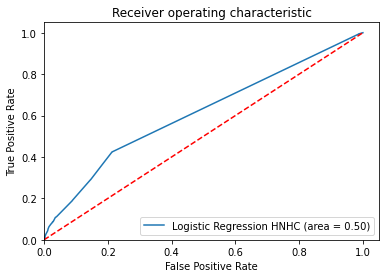

In [33]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression HNHC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_ROC_10')
plt.show()

In [34]:
# K-Fold Validation using Logistic Regression
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.144004    0.009391      0.600597       0.600690             0.0   
1  0.139688    0.007979      0.591409       0.602442             0.0   
2  0.151849    0.009009      0.611893       0.599457             0.0   
3  0.131060    0.008855      0.609763       0.599704             0.0   
4  0.142966    0.008812      0.577258       0.603575             0.0   
5  0.138780    0.006993      0.606866       0.600215             0.5   
6  0.136908    0.007983      0.578814       0.603174             1.0   
7  0.123083    0.007979      0.607597       0.600288             1.0   
8  0.125574    0.008233      0.605282       0.600999             0.0   
9  0.129769    0.008069      0.609218       0.599938             0.0   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.500000     0.000000      0.000707       0.900232        0.900495  
1         0.600000     0.000000      0.000707       0.900232        0.900518  
2         0.500000     0.000000      0.000707       0.900633        0.900473  
3         0.500000     0.000000      0.000707       0.900633        0.900473  
4         0.428571     0.000000      0.000707       0.900422        0.900450  
5         0.500000     0.002119      0.000471       0.900422        0.900497  
6         0.400000     0.002119      0.000471       0.900633        0.900473  
7         0.285714     0.002119      0.000471       0.900633        0.900427  
8         0.500000     0.000000      0.000707       0.900422        0.900497  
9         0.500000     0.000000      0.000707       0.900422        0.900497

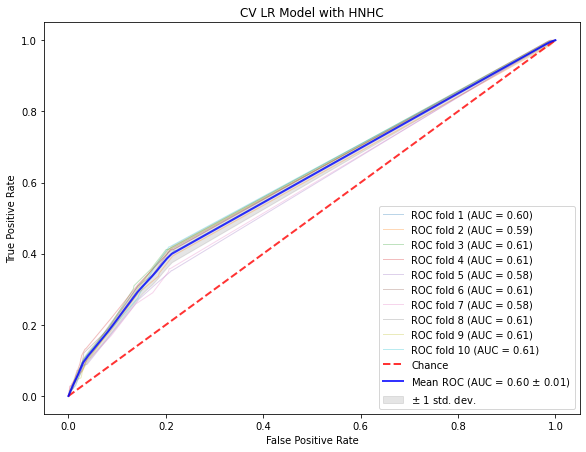

In [35]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV LR Model with HNHC')

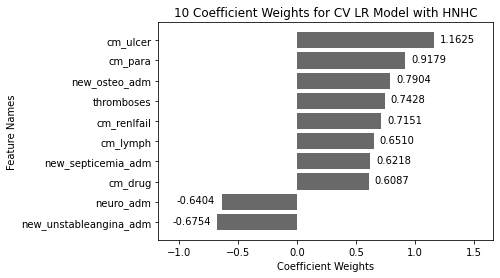

In [48]:
# Grab the feature importance using the Logistic Regression model
for value in model.coef_:
    importance = sorted(zip(value, X_train))

# Graph feature importance for Logistic Regression
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    if value_labels[index] >= 0:
        plt.text(value/value_labels[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels[index] < 0:
        plt.text(-value/value_labels[index]+value+0.72, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels)-0.5, max(value_labels)+0.5))
plt.ylabel('Feature Names')
plt.title('10 Coefficient Weights for CV LR Model with HNHC')
plt.savefig('images\Logistic_Regression_HNHC_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE - HNHC <a class="anchor" id="dtchnhc"></a> 

[Return to Table of Contents](#contents)

In [49]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['gi_bleed_adm' 'age' 'los' 'orproc' 'cm_psych' 'cm_renlfail' 'cc_index'
 'chronic_pain' 'frailty_risk_score' 'hosp_bedsize']


       hnhc_patients  gi_bleed_adm  age  los  orproc  cm_psych  cm_renlfail  \
0                  0             0   89    4       0         0            0   
3                  0             0   48    4       1         0            0   
4                  1             0   65    5       0         0            0   
9                  0             0   51    3       1         0            0   
10                 0             0   22    6       1         0            0   
...              ...           ...  ...  ...     ...       ...          ...   
94491              0             0   32    3       0         0            0   
94492              0             0   54    4       1         0            0   
94493              1             0   44    9       1         0            0   
94496              0             0   52    2       1         0            0   
944

In [50]:
# Initial model with Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9176113189502405
Testing Score: 0.9206817990043035


In [51]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

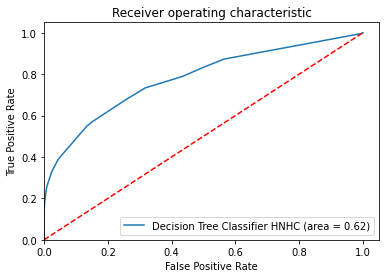

In [52]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier HNHC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_HNHC_ROC_10')
plt.show()

In [53]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.043188    0.010177      0.785252       0.792074        0.861702   
1  0.043753    0.010031      0.767245       0.793990        0.766990   
2  0.046630    0.010049      0.773322       0.793316        0.822581   
3  0.041676    0.009008      0.803214       0.789648        0.788235   
4  0.040507    0.008987      0.780326       0.793498        0.810811   
5  0.043801    0.008413      0.791492       0.791074        0.857143   
6  0.042829    0.009615      0.787126       0.792133        0.869565   
7  0.041363    0.008624      0.771502       0.790031        0.894231   
8  0.042779    0.008816      0.791619       0.791434        0.818792   
9  0.041888    0.008259      0.790967       0.790549        0.738854   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.894416     0.171610      0.207538       0.914786        0.918708  
1         0.850838     0.167373      0.227091       0.912044        0.919130  
2         0.879024     0.216561      0.212200       0.917511        0.918686  
3         0.762544     0.284501      0.254122       0.921308        0.917889  
4         0.880383     0.191083      0.216675       0.915190        0.919108  
5         0.861972     0.216102      0.216254       0.918354        0.918569  
6         0.867240     0.211864      0.213899       0.918354        0.918522  
7         0.908306     0.197034      0.198351       0.917722        0.918241  
8         0.832759     0.258475      0.227562       0.920464        0.918593  
9         0.809041     0.245763      0.244523       0.916245        0.919085

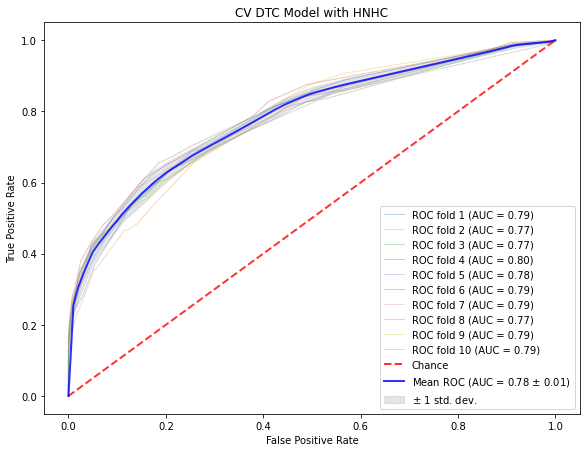

In [54]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV DTC Model with HNHC')

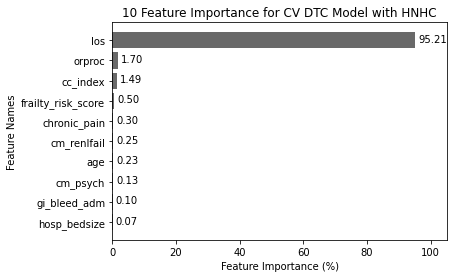

In [55]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for CV DTC Model with HNHC')
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_Feature_Importance_10')
plt.show()

## XGBoost Classifier RFE - HNHC <a class="anchor" id="xgbchnhc"></a>

[Return to Table of Contents](#contents)

In [56]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['steroid_use' 'los' 'orproc' 'payer' 'cm_depress' 'cm_dmcx' 'cm_drug'
 'cc_index' 'thromboses' 'chronic_pain']


       hnhc_patients  steroid_use  los  orproc  payer  cm_depress  cm_dmcx  \
0                  0            0    4       0    1.0           0        0   
3                  0            0    4       1    2.0           0        0   
4                  1            0    5       0    1.0           0        0   
9                  0            0    3       1    2.0           0        0   
10                 0            0    6       1    1.0           0        0   
...              ...          ...  ...     ...    ...         ...      ...   
94491              0            0    3       0    2.0           0        0   
94492              0            0    4       1    2.0           0        0   
94493              1            0    9       1    2.0           0        0   
94496              0            0    2       1    1.0           1        0   
94497              0        

In [57]:
# Initial model with XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9236856185407338
Testing Score: 0.91628653488765


In [58]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

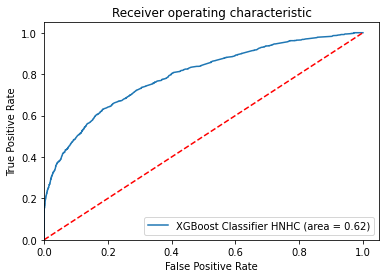

In [59]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier HNHC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGBClassifier_HNHC_ROC_10')
plt.show()

In [60]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.825049    0.027925      0.785996       0.829815        0.730769   
1  0.753781    0.025535      0.781269       0.829251        0.664122   
2  0.770464    0.027805      0.788318       0.829393        0.758389   
3  0.763836    0.023777      0.798602       0.827841        0.764706   
4  0.764534    0.020857      0.777948       0.829381        0.746269   
5  0.760955    0.028531      0.804558       0.827021        0.794326   
6  0.758600    0.026980      0.797708       0.828738        0.758621   
7  0.761397    0.024413      0.789341       0.829639        0.814286   
8  0.763049    0.027590      0.801611       0.827968        0.775641   
9  0.865207    0.022743      0.798608       0.828065        0.739130   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.874717     0.201699      0.273156       0.913200        0.923734  
1         0.883058     0.184713      0.277634       0.909609        0.924415  
2         0.882168     0.239915      0.264671       0.916790        0.923265  
3         0.876923     0.248408      0.268678       0.917635        0.923429  
4         0.875680     0.212314      0.265614       0.914467        0.923124  
5         0.876154     0.237288      0.268505       0.917846        0.923405  
6         0.881303     0.233051      0.267798       0.916156        0.923523  
7         0.868056     0.241525      0.265205       0.918902        0.922842  
8         0.882716     0.256356      0.269684       0.918479        0.923734  
9         0.874422     0.252654      0.267499       0.916772        0.923243

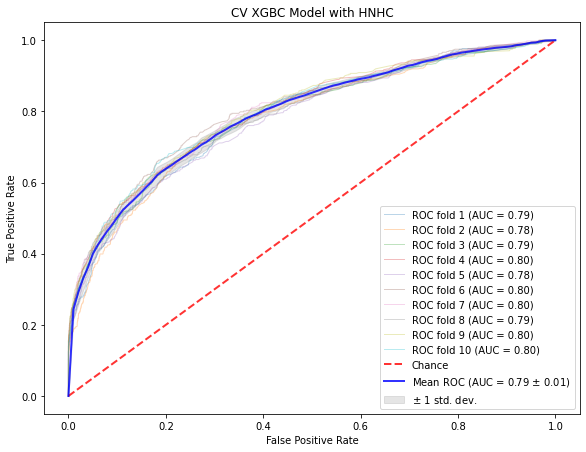

In [61]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV XGBC Model with HNHC')

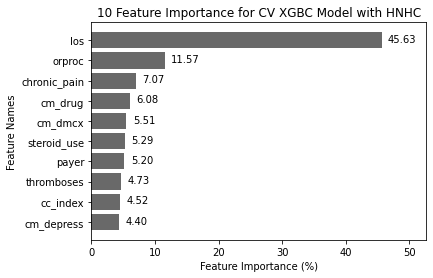

In [66]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+7))
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for CV XGBC Model with HNHC')
plt.savefig('images\XGBClassifier_HNHC_Feature_Importance_10')
plt.show()

## Target: HNHC without 'los' <a class="anchor" id="hnhcwolos"></a> 

[Return to Table of Contents](#contents)

## Logistic Regression RFE - HNHC without 'los' <a class="anchor" id="lrhnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [67]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
model = LogisticRegression(random_state=42)
X = cleaned_data_wo_outcome_hnhc_no_los
dataset = cleaned_data_hnhc_no_los

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['severe_IBD_hospitalization' 'cm_dmcx' 'cm_lymph' 'cm_para' 'cm_ulcer'
 'pq1_dm_short' 'pq2_perf_appendix' 'new_unstableangina_adm'
 'new_meningitis_adm' 'new_atypicalmyco_adm']


       hnhc_patients  severe_IBD_hospitalization  cm_dmcx  cm_lymph  cm_para  \
0                  0                           0        0         0        0   
3                  0                           0        0         0        0   
4                  1                           0        0         0        0   
9                  0                           0        0         0        0   
10                 0                           0        0         0        0   
...              ...                         ...      ...       ...      ...   
94491              0                           0        0         0        0   
94492              0                           0        0         0        0   
94493              1                           1        0         0        0   
94496              

In [68]:
# Initial model with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.8993839835728953
Testing Score: 0.9031305375073834


In [69]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

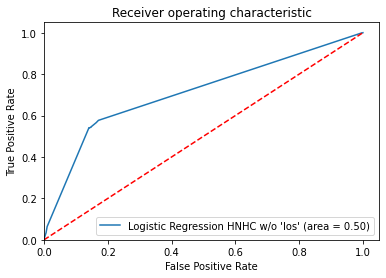

In [70]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression HNHC w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_HNHC_no_los_ROC_10')
plt.show()

In [71]:
# K-Fold Validation using Logistic Regression
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.212083    0.009837      0.714134       0.715222        0.666667   
1  0.234143    0.008389      0.685640       0.718244        0.500000   
2  0.166586    0.008465      0.705140       0.716201        0.500000   
3  0.220778    0.008985      0.735480       0.712812        0.600000   
4  0.241332    0.008614      0.720255       0.714503        0.000000   
5  0.199375    0.009007      0.726263       0.713703        0.000000   
6  0.205318    0.008036      0.731205       0.713157        0.500000   
7  0.157357    0.008609      0.695863       0.717057        0.500000   
8  0.190378    0.008345      0.711777       0.715458        0.333333   
9  0.165029    0.009492      0.723294       0.714204        0.000000   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.354839     0.004237      0.002591       0.900654        0.900284  
1         0.454545     0.008475      0.003534       0.900443        0.900424  
2         0.387097     0.002123      0.002826       0.900633        0.900309  
3         0.344828     0.006369      0.002355       0.900844        0.900263  
4         0.500000     0.000000      0.004475       0.900000        0.900473  
5         0.461538     0.000000      0.002827       0.900000        0.900450  
6         0.423077     0.002119      0.002591       0.900422        0.900403  
7         0.423077     0.002119      0.002591       0.900422        0.900403  
8         0.454545     0.004237      0.002356       0.900000        0.900450  
9         0.433333     0.000000      0.003062       0.899578        0.900403

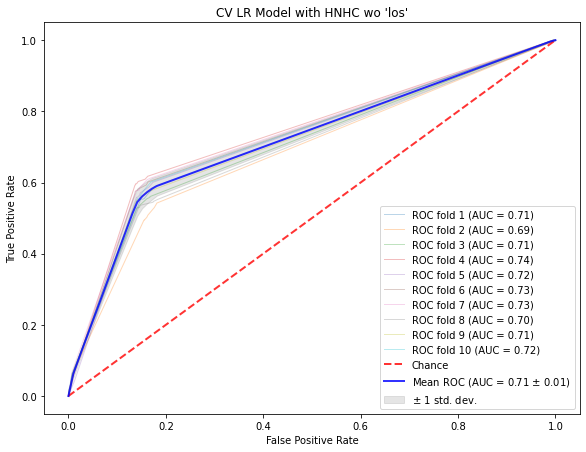

In [72]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV LR Model with HNHC wo 'los'")

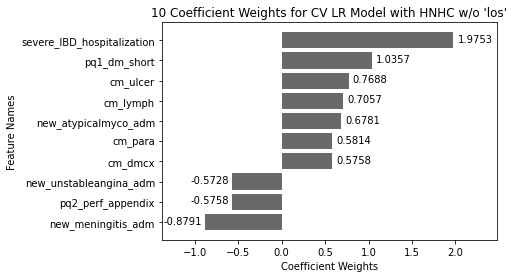

In [73]:
# Grab the feature importance using the Logistic Regression model
for value in model.coef_:
    importance = sorted(zip(value, X_train))

# Graph feature importance for Logistic Regression
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    if value_labels[index] >= 0:
        plt.text(value/value_labels[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels[index] < 0:
        plt.text(-value/value_labels[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels)-0.5, max(value_labels)+0.5))
plt.ylabel('Feature Names')
plt.title("10 Coefficient Weights for CV LR Model with HNHC w/o 'los'")
plt.savefig('images\Logistic_Regression_HNHC_no_los_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE - HNHC without 'los' <a class="anchor" id="dtchnhcwolos"></a> 

[Return to Table of Contents](#contents)

In [74]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['age' 'orproc' 'payer' 'severe_IBD_hospitalization' 'cm_drug'
 'cm_wghtloss' 'blood_transfusion' 'cc_index' 'new_arrhythmia_adm'
 'frailty_risk_score']


       hnhc_patients  age  orproc  payer  severe_IBD_hospitalization  cm_drug  \
0                  0   89       0    1.0                           0        0   
3                  0   48       1    2.0                           0        0   
4                  1   65       0    1.0                           0        0   
9                  0   51       1    2.0                           0        0   
10                 0   22       1    1.0                           0        0   
...              ...  ...     ...    ...                         ...      ...   
94491              0   32       0    2.0                           0        0   
94492              0   54       1    2.0                           0        0   
94493              1   44       1    2.0                           1        0   
94496              0   52       1  

In [75]:
# Initial model with Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9016079524654332
Testing Score: 0.9050515289744889


In [76]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

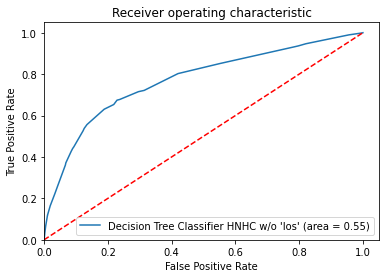

In [77]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Decision Tree Classifier HNHC w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_no_los_HNHC_ROC_10')
plt.show()

In [78]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.040645    0.007980      0.763680       0.777674        0.511364   
1  0.038737    0.009423      0.743212       0.778340        0.352113   
2  0.047673    0.007519      0.767634       0.776565        0.543689   
3  0.037314    0.008968      0.773716       0.776027        0.583333   
4  0.038175    0.008412      0.759856       0.778129        0.656250   
5  0.037580    0.008596      0.790132       0.774487        0.533333   
6  0.037026    0.008835      0.777159       0.776359        0.526882   
7  0.036575    0.008611      0.765082       0.776262        0.593750   
8  0.037449    0.007546      0.762154       0.777521        0.510870   
9  0.036238    0.008379      0.784418       0.775369        0.545455   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.561547     0.095541      0.112892       0.900950        0.902896  
1         0.583832     0.053079      0.091916       0.896093        0.903060  
2         0.555689     0.118896      0.109357       0.902429        0.902614  
3         0.559880     0.089172      0.088145       0.903062        0.902309  
4         0.572594     0.089172      0.082724       0.904752        0.902520  
5         0.608076     0.050847      0.060349       0.900950        0.902591  
6         0.553350     0.103814      0.105139       0.901373        0.902473  
7         0.558346     0.080508      0.089109       0.902851        0.902309  
8         0.584187     0.099576      0.094059       0.900739        0.903154  
9         0.614458     0.050955      0.048079       0.901352        0.902218

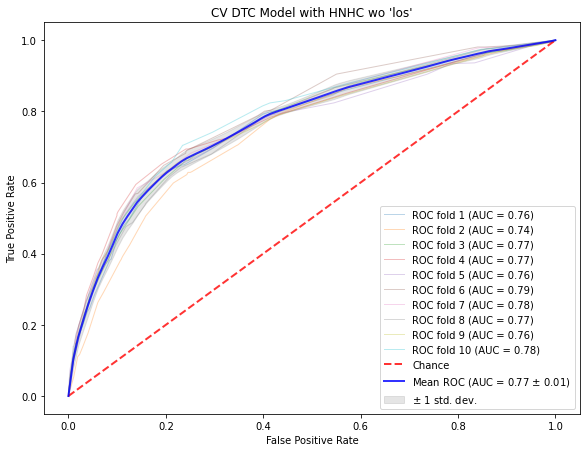

In [79]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV DTC Model with HNHC wo 'los'")

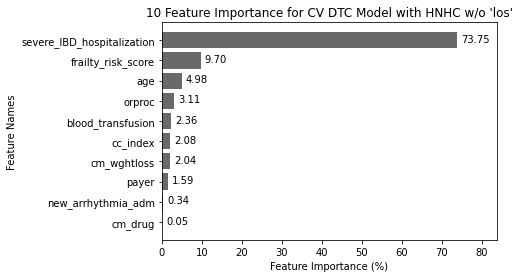

In [80]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("10 Feature Importance for CV DTC Model with HNHC w/o 'los'")
plt.savefig('images\CV_Decision_Tree_Classifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## XGBoost Classifier RFE - HNHC without 'los' <a class="anchor" id="xgbchnhcwolos"></a>

[Return to Table of Contents](#contents)

In [81]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['orproc' 'payer' 'severe_IBD_hospitalization' 'cm_dmcx' 'cm_drug'
 'cm_wghtloss' 'blood_transfusion' 'cc_index' 'thromboses' 'chronic_pain']


       hnhc_patients  orproc  payer  severe_IBD_hospitalization  cm_dmcx  \
0                  0       0    1.0                           0        0   
3                  0       1    2.0                           0        0   
4                  1       0    1.0                           0        0   
9                  0       1    2.0                           0        0   
10                 0       1    1.0                           0        0   
...              ...     ...    ...                         ...      ...   
94491              0       0    2.0                           0        0   
94492              0       1    2.0                           0        0   
94493              1       1    2.0                           1        0   
94496              0       1    1.0                           0        0   
94497              0

In [82]:
# Initial model with XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.9052406296640477
Testing Score: 0.9026017908430478


In [83]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

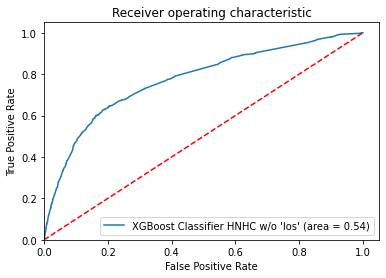

In [84]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="XGBoost Classifier HNHC w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGBClassifier_HNHC_no_los_ROC_10')
plt.show()

In [85]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.749942    0.027846      0.761059       0.789101        0.611940   
1  0.706833    0.024770      0.746943       0.790228        0.361446   
2  0.710300    0.020831      0.774358       0.787795        0.506494   
3  0.684620    0.022830      0.766505       0.788590        0.428571   
4  0.694474    0.020797      0.748227       0.790624        0.384615   
5  0.692896    0.021253      0.792733       0.785985        0.560976   
6  0.691432    0.022018      0.778592       0.786881        0.591837   
7  0.701851    0.020716      0.754769       0.789459        0.513889   
8  0.697443    0.025088      0.758425       0.789359        0.465116   
9  0.691494    0.022404      0.770874       0.787811        0.507692   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.668217     0.087049      0.101579       0.903696        0.905524  
1         0.679219     0.063694      0.114777       0.895671        0.906463  
2         0.681538     0.082803      0.104407       0.900739        0.905970  
3         0.694534     0.082803      0.101815       0.897782        0.906111  
4         0.683983     0.053079      0.111713       0.897360        0.906416  
5         0.669826     0.097458      0.099953       0.902429        0.905501  
6         0.680645     0.061441      0.099481       0.902218        0.905712  
7         0.673780     0.078390      0.104196       0.900739        0.905806  
8         0.685039     0.084746      0.102546       0.899050        0.905970  
9         0.700840     0.070064      0.098280       0.900718        0.906042

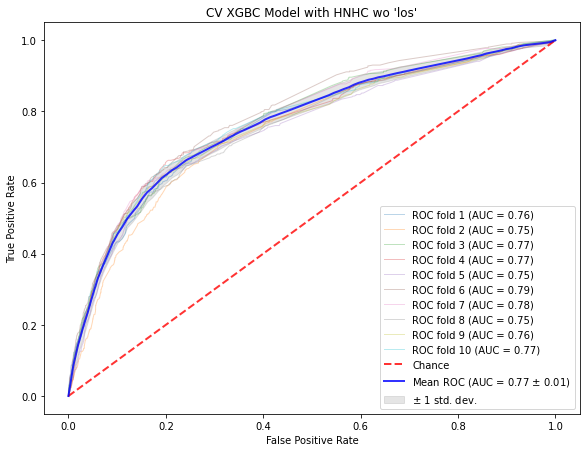

In [86]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV XGBC Model with HNHC wo 'los'")

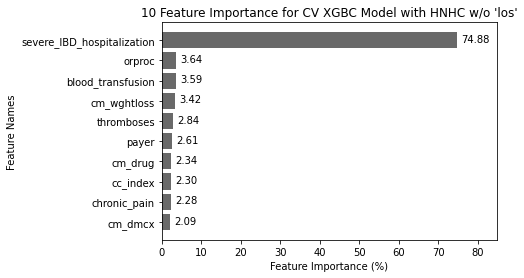

In [87]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+10))
plt.ylabel('Feature Names')
plt.title("10 Feature Importance for CV XGBC Model with HNHC w/o 'los'")
plt.savefig('images\XGBClassifier_HNHC_no_los_Feature_Importance_10')
plt.show()

## Target: IBD_READM <a class="anchor" id="ibd"></a> 

[Return to Table of Contents](#contents)

## Logistic Regression RFE - IBD_READM <a class="anchor" id="lribd"></a> 

[Return to Table of Contents](#contents)

In [88]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
model = LogisticRegression(random_state=42)
X = cleaned_data_wo_outcome_readmit
y = target_readmit
dataset = cleaned_data_readmit
target = 'ibd_readm'

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['cm_dmcx' 'pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_encephalitis_adm' 'new_tb_adm' 'new_atypicalmyco_adm'
 'new_fungal_adm' 'new_listeriosis_adm' 'chronic_pain']


      ibd_readm  cm_dmcx  pq16_dm_amputate  new_cardiacarrest_adm  \
0             1        0                 0                      0   
3             0        0                 0                      0   
4             1        0                 0                      0   
9             0        0                 0                      0   
10            0        0                 0                      0   
...         ...      ...               ...                    ...   
94491         0        0                 0                      0   
94492         0        0                 0                      0   
94493         1        0                 0                      0   
94496         0        0                 0                      0   
94497         0        0                 0      

In [89]:
# Initial model with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.590363140277348
Testing Score: 0.5997806092312885


In [90]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

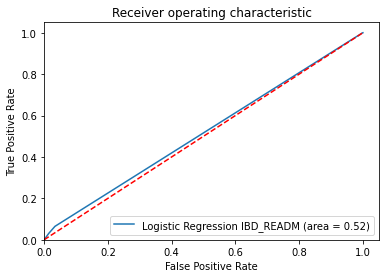

In [91]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression IBD_READM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_ROC_10')
plt.show()

In [92]:
# K-Fold Validation using Logistic Regression
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.134902    0.011846      0.513960       0.516247        0.559809   
1  0.116720    0.008564      0.522608       0.515285        0.631579   
2  0.127914    0.009013      0.514863       0.516144        0.564220   
3  0.123936    0.009007      0.516276       0.515989        0.578704   
4  0.136019    0.007716      0.516332       0.515983        0.561983   
5  0.114462    0.010416      0.514597       0.516175        0.556561   
6  0.114927    0.008976      0.512937       0.516398        0.541485   
7  0.122439    0.009568      0.514831       0.516148        0.547325   
8  0.123296    0.008563      0.515635       0.516052        0.577114   
9  0.118086    0.008958      0.518010       0.515795        0.601896   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.573207     0.059603      0.065172       0.591225        0.592907  
1         0.565108     0.073357      0.063643       0.598608        0.592086  
2         0.572500     0.062659      0.064832       0.591772        0.592823  
3         0.571214     0.063678      0.064719       0.593038        0.592705  
4         0.573165     0.069317      0.064092       0.592405        0.592776  
5         0.573647     0.062691      0.064828       0.591350        0.592893  
6         0.575453     0.063201      0.064772       0.590084        0.593034  
7         0.574975     0.067788      0.064262       0.590928        0.592940  
8         0.571429     0.059123      0.065225       0.592616        0.592752  
9         0.568794     0.064730      0.064602       0.595148        0.592471

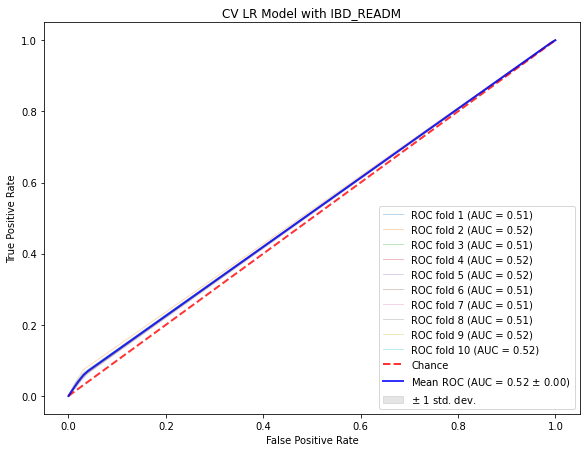

In [93]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV LR Model with IBD_READM')

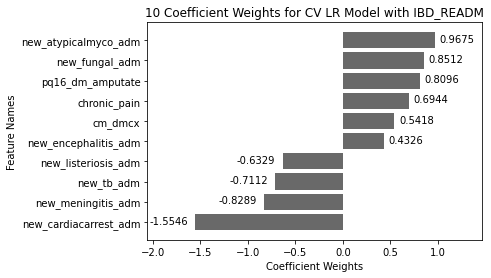

In [94]:
# Grab the feature importance using the Logistic Regression model
for value in model.coef_:
    importance = sorted(zip(value, X_train))

# Graph feature importance for Logistic Regression
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    if value_labels[index] >= 0:
        plt.text(value/value_labels[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels[index] < 0:
        plt.text(-value/value_labels[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels)-0.5, max(value_labels)+0.5))
plt.ylabel('Feature Names')
plt.title('10 Coefficient Weights for CV LR Model with IBD_READM')
plt.savefig('images\Logistic_Regression_IBD_READM_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE - IBD_READM <a class="anchor" id="dtcibd"></a> 

[Return to Table of Contents](#contents)

In [95]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['age' 'los' 'orproc' 'payer' 'cm_anemdef' 'cm_wghtloss' 'ibd_procedures'
 'cc_index' 'frailty_risk_score' 'ibd_specific_adm']


      ibd_readm  age  los  orproc  payer  cm_anemdef  cm_wghtloss  \
0             1   89    4       0    1.0           1            0   
3             0   48    4       1    2.0           0            0   
4             1   65    5       0    1.0           1            0   
9             0   51    3       1    2.0           0            0   
10            0   22    6       1    1.0           0            0   
...         ...  ...  ...     ...    ...         ...          ...   
94491         0   32    3       0    2.0           0            0   
94492         0   54    4       1    2.0           0            0   
94493         1   44    9       1    2.0           0            0   
94496         0   52    2       1    1.0           0            0   
94497         0   72    4       0    1.0           0            0   

       ibd_procedures  cc_index  frailty_r

In [96]:
# Initial model with Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.6120357072456422
Testing Score: 0.6071971616827166


In [97]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

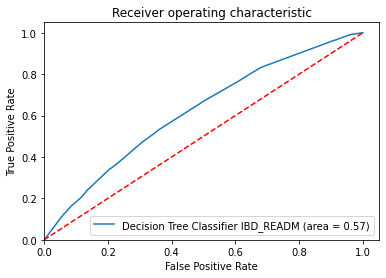

In [98]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree Classifier IBD_READM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_ROC_10')
plt.show()

In [99]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.047949    0.011599      0.611699       0.625769        0.539581   
1  0.053389    0.013068      0.615431       0.624563        0.542219   
2  0.044512    0.009966      0.625628       0.624121        0.561062   
3  0.045744    0.009974      0.623117       0.624231        0.538462   
4  0.062264    0.012932      0.614955       0.625096        0.520973   
5  0.048875    0.009832      0.615819       0.624988        0.566419   
6  0.048654    0.009805      0.611951       0.625855        0.526135   
7  0.043333    0.010648      0.617850       0.624808        0.542857   
8  0.053439    0.008798      0.627590       0.623271        0.547516   
9  0.045392    0.009572      0.604983       0.626248        0.519325   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.559858     0.302397      0.312284       0.604224        0.613672  
1         0.545154     0.334013      0.336035       0.607392        0.609072  
2         0.545826     0.323469      0.325417       0.615206        0.608626  
3         0.546779     0.332143      0.336243       0.605702        0.609823  
4         0.553883     0.316837      0.329498       0.596621        0.612545  
5         0.562605     0.271939      0.283981       0.612460        0.612170  
6         0.550371     0.313265      0.328251       0.598944        0.610879  
7         0.542585     0.368367      0.365435       0.610137        0.609753  
8         0.567961     0.258673      0.267883       0.604646        0.612545  
9         0.539275     0.377041      0.381363       0.597592        0.609011

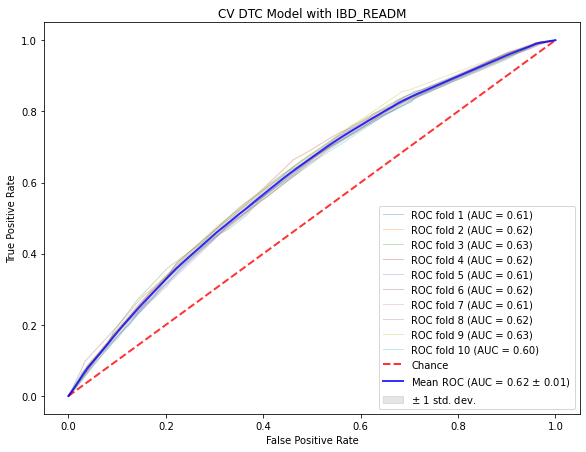

In [100]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV DTC Model with IBD_READM')

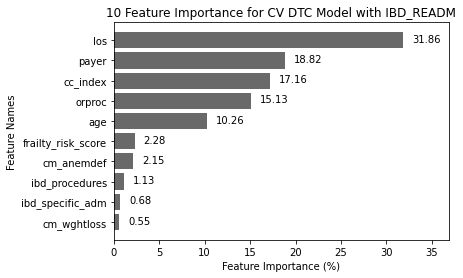

In [101]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+5))
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for CV DTC Model with IBD_READM')
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_Feature_Importance_10')
plt.show()

## XGBoost Classifier RFE - IBD_READM <a class="anchor" id="xgbcibd"></a>

[Return to Table of Contents](#contents)

In [102]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['steroid_use' 'elective' 'orproc' 'payer' 'cm_drug' 'ibd_procedures'
 'cc_index' 'thromboses' 'chronic_pain' 'ibd_specific_adm']


      ibd_readm  steroid_use  elective  orproc  payer  cm_drug  \
0             1            0       0.0       0    1.0        0   
3             0            0       1.0       1    2.0        0   
4             1            0       0.0       0    1.0        0   
9             0            0       0.0       1    2.0        0   
10            0            0       1.0       1    1.0        0   
...         ...          ...       ...     ...    ...      ...   
94491         0            0       0.0       0    2.0        0   
94492         0            0       1.0       1    2.0        0   
94493         1            0       1.0       1    2.0        0   
94496         0            0       1.0       1    1.0        0   
94497         0            0       0.0       0    1.0        0   

       ibd_procedures  cc_index  thromboses  chronic_pain  ibd_specific_adm

In [103]:
# Initial model with XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.6187670885362347
Testing Score: 0.6018941315744969


In [104]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

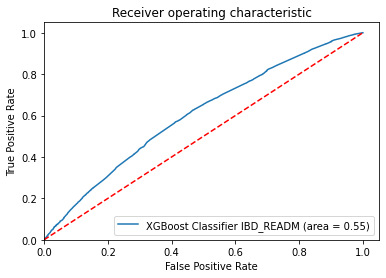

In [105]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label='XGBoost Classifier IBD_READM (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGBClassifier_IBD_READM_ROC_10')
plt.show()

In [106]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.745061    0.026474      0.606795       0.636304        0.532676   
1  0.684072    0.024865      0.608506       0.635526        0.546380   
2  0.700597    0.022616      0.624648       0.634153        0.553012   
3  0.689569    0.023791      0.607734       0.635972        0.545657   
4  0.683455    0.027792      0.607316       0.636017        0.542998   
5  0.697379    0.024752      0.615493       0.635535        0.557398   
6  0.699688    0.023799      0.609740       0.635989        0.549043   
7  0.701486    0.020866      0.619928       0.634470        0.547145   
8  0.699428    0.018799      0.611801       0.635279        0.528834   
9  0.697574    0.030003      0.603237       0.636523        0.551643   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.592920     0.220521      0.247078       0.597125        0.618035  
1         0.583248     0.246554      0.258765       0.603255        0.616555  
2         0.587948     0.234303      0.252411       0.604523        0.617237  
3         0.586004     0.250128      0.260354       0.603171        0.617621  
4         0.588616     0.225625      0.247589       0.600634        0.616846  
5         0.593373     0.223187      0.242809       0.605074        0.617598  
6         0.589144     0.234423      0.248766       0.603383        0.617128  
7         0.592944     0.210419      0.237420       0.601057        0.616776  
8         0.589178     0.220123      0.254496       0.595983        0.617856  
9         0.589078     0.240041      0.249674       0.604651        0.617222

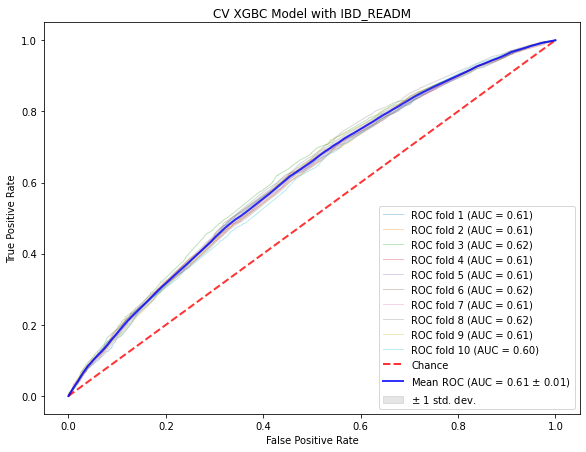

In [107]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, 'CV XGBC Model with IBD_READM')

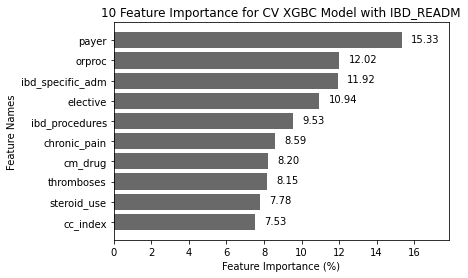

In [113]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value-0.5, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+2.5))
plt.ylabel('Feature Names')
plt.title('10 Feature Importance for CV XGBC Model with IBD_READM')
plt.savefig('images\XGBClassifier_IBD_READM_Feature_Importance_10')
plt.show()

## Target: IBD_READM without 'los' <a class="anchor" id="ibdwolos"></a> 

[Return to Table of Contents](#contents)

## Logistic Regression RFE - IBD_READM without 'los' <a class="anchor" id="lribdwolos"></a> 

[Return to Table of Contents](#contents)

In [114]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Logistic Regression
model = LogisticRegression(random_state=42)
X = cleaned_data_wo_outcome_readmit_no_los
dataset = cleaned_data_readmit_no_los

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['cm_dmcx' 'pq16_dm_amputate' 'new_cardiacarrest_adm' 'new_meningitis_adm'
 'new_encephalitis_adm' 'new_tb_adm' 'new_atypicalmyco_adm'
 'new_fungal_adm' 'new_listeriosis_adm' 'chronic_pain']


      ibd_readm  cm_dmcx  pq16_dm_amputate  new_cardiacarrest_adm  \
0             1        0                 0                      0   
3             0        0                 0                      0   
4             1        0                 0                      0   
9             0        0                 0                      0   
10            0        0                 0                      0   
...         ...      ...               ...                    ...   
94491         0        0                 0                      0   
94492         0        0                 0                      0   
94493         1        0                 0                      0   
94496         0        0                 0                      0   
94497         0        0                 0      

In [115]:
# Initial model with Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.590363140277348
Testing Score: 0.5997806092312885


In [116]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

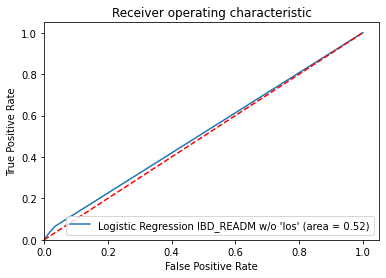

In [117]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Logistic Regression IBD_READM w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_ROC_10')
plt.show()

In [118]:
# K-Fold Validation using Logistic Regression
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.144518    0.010971      0.513960       0.516247        0.559809   
1  0.112178    0.008408      0.522608       0.515285        0.631579   
2  0.127767    0.009163      0.514863       0.516144        0.564220   
3  0.125536    0.008984      0.516276       0.515989        0.578704   
4  0.140733    0.008975      0.516332       0.515983        0.561983   
5  0.117361    0.008999      0.514597       0.516175        0.556561   
6  0.123116    0.008798      0.512937       0.516398        0.541485   
7  0.118976    0.008975      0.514831       0.516148        0.547325   
8  0.124140    0.008728      0.515635       0.516052        0.577114   
9  0.114889    0.010004      0.518010       0.515795        0.601896   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.573207     0.059603      0.065172       0.591225        0.592907  
1         0.565108     0.073357      0.063643       0.598608        0.592086  
2         0.572500     0.062659      0.064832       0.591772        0.592823  
3         0.571214     0.063678      0.064719       0.593038        0.592705  
4         0.573165     0.069317      0.064092       0.592405        0.592776  
5         0.573647     0.062691      0.064828       0.591350        0.592893  
6         0.575453     0.063201      0.064772       0.590084        0.593034  
7         0.574975     0.067788      0.064262       0.590928        0.592940  
8         0.571429     0.059123      0.065225       0.592616        0.592752  
9         0.568794     0.064730      0.064602       0.595148        0.592471

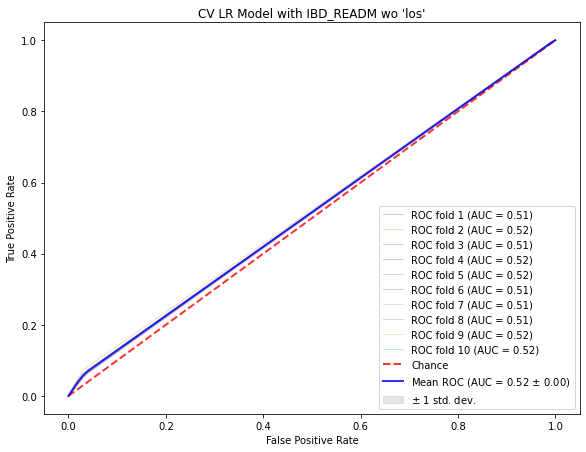

In [119]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=10)
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV LR Model with IBD_READM wo 'los'")

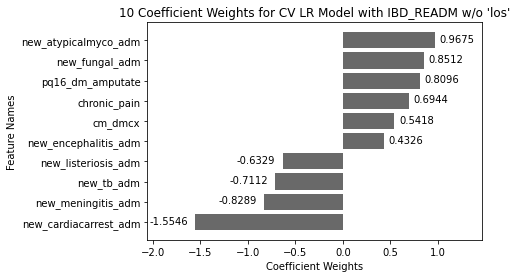

In [120]:
# Grab the feature importance using the Logistic Regression model
for value in model.coef_:
    importance = sorted(zip(value, X_train))

# Graph feature importance for Logistic Regression
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    if value_labels[index] >= 0:
        plt.text(value/value_labels[index]+value-0.95, index-0.09, str(f'{value:.4f}'), color='black')
    elif value_labels[index] < 0:
        plt.text(-value/value_labels[index]+value+0.52, index-0.09, str(f'{value:.4f}'), color='black')
plt.xlabel('Coefficient Weights')
plt.xlim((min(value_labels)-0.5, max(value_labels)+0.5))
plt.ylabel('Feature Names')
plt.title("10 Coefficient Weights for CV LR Model with IBD_READM w/o 'los'")
plt.savefig('images\Logistic_Regression_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## Decision Tree Classifier RFE - IBD_READM without 'los' <a class="anchor" id="dtcibdwolos"></a> 

[Return to Table of Contents](#contents)

In [121]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42, splitter = "best", max_depth = 5)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['age' 'orproc' 'payer' 'severe_IBD_hospitalization' 'ibd_procedures'
 'cc_index' 'thromboses' 'frailty_risk_score' 'hosp_urcat4'
 'ibd_specific_adm']


      ibd_readm  age  orproc  payer  severe_IBD_hospitalization  \
0             1   89       0    1.0                           0   
3             0   48       1    2.0                           0   
4             1   65       0    1.0                           0   
9             0   51       1    2.0                           0   
10            0   22       1    1.0                           0   
...         ...  ...     ...    ...                         ...   
94491         0   32       0    2.0                           0   
94492         0   54       1    2.0                           0   
94493         1   44       1    2.0                           1   
94496         0   52       1    1.0                           0   
94497         0   72       0    1.0                           0   

       ibd_procedures  cc_index  thrombose

In [122]:
# Initial model with Decision Tree Classifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.6102616090788769
Testing Score: 0.6007771583037675


In [123]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])


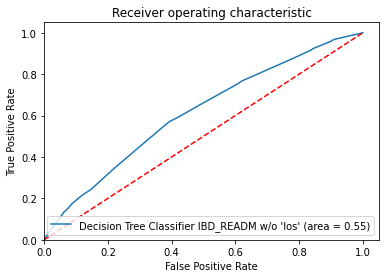

In [124]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="Decision Tree Classifier IBD_READM w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\Decision_Tree_Classifier_IBD_READM_no_los_ROC_10')
plt.show()

In [125]:
# K-Fold Validation using Decision Tree Classifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.042726    0.009747      0.607813       0.619772        0.510383   
1  0.044060    0.008979      0.607592       0.619610        0.529412   
2  0.039269    0.009299      0.614770       0.618798        0.547150   
3  0.039759    0.008943      0.610568       0.618259        0.555676   
4  0.040968    0.008664      0.611052       0.618517        0.538241   
5  0.038710    0.008975      0.618649       0.619045        0.569556   
6  0.039576    0.008976      0.608049       0.618289        0.562865   
7  0.037815    0.009716      0.617255       0.619153        0.535971   
8  0.040293    0.010004      0.617518       0.619888        0.540299   
9  0.039824    0.008977      0.603691       0.620713        0.551471   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.561982     0.238144      0.265461       0.589863        0.610269  
1         0.572583     0.220296      0.241029       0.595987        0.611325  
2         0.560511     0.269388      0.278540       0.605280        0.610903  
3         0.561059     0.262245      0.259381       0.607814        0.609377  
4         0.550449     0.287245      0.291917       0.602957        0.608157  
5         0.556171     0.288265      0.290443       0.615206        0.610292  
6         0.580803     0.196429      0.208196       0.604224        0.609987  
7         0.552009     0.304082      0.306825       0.602957        0.609940  
8         0.559371     0.277041      0.296395       0.603168        0.612052  
9         0.575841     0.229592      0.226165       0.603718        0.610677

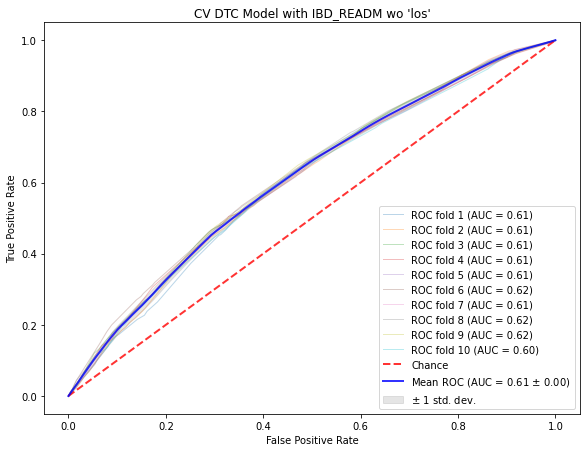

In [126]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV DTC Model with IBD_READM wo 'los'")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


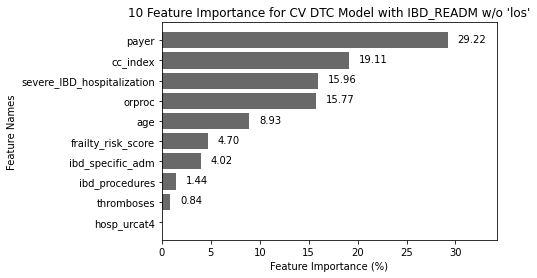

In [127]:
# Grab the feature importance using the cross validation Decision Tree Classifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for Decision Tree Classifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+5))
plt.ylabel('Feature Names')
plt.title("10 Feature Importance for CV DTC Model with IBD_READM w/o 'los'")
plt.savefig('images\CV_Decision_Tree_Classifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()

## XGBoost Classifier Model - IBD_READM without 'los' <a class="anchor" id="xgbcibdwolos"></a>

[Return to Table of Contents](#contents)

In [129]:
# Use Recursive Feature Elimination (RFE) to select the 10 most important features with XGBClassifier
model = XGBClassifier(random_state=42, verbosity = 0)

cleaned_data_wo_outcome_df, target_srs = rfe_feature_selection(model, num_features, X, y, dataset, target, readmission_df)

['steroid_use' 'elective' 'orproc' 'payer' 'severe_IBD_hospitalization'
 'cm_anemdef' 'cm_drug' 'ibd_procedures' 'chronic_pain' 'ibd_specific_adm']


      ibd_readm  steroid_use  elective  orproc  payer  \
0             1            0       0.0       0    1.0   
3             0            0       1.0       1    2.0   
4             1            0       0.0       0    1.0   
9             0            0       0.0       1    2.0   
10            0            0       1.0       1    1.0   
...         ...          ...       ...     ...    ...   
94491         0            0       0.0       0    2.0   
94492         0            0       1.0       1    2.0   
94493         1            0       1.0       1    2.0   
94496         0            0       1.0       1    1.0   
94497         0            0       0.0       0    1.0   

       severe_IBD_hospitalization  cm_anemdef  cm_drug  ibd_procedures  \
0                               0           1        0               0   
3                

In [130]:
# Initial model with XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_wo_outcome_df, target_srs, random_state=42)
model.fit(X_train, y_train)
print(f'Training Score: {model.score(X_train, y_train)}')
print(f'Testing Score: {model.score(X_test, y_test)}')

Training Score: 0.6133269442173803
Testing Score: 0.5991036698799256


In [131]:
# Creating ROC/AUC chart values
roc_auc = roc_auc_score(y_test.values, model.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test.values, model.predict_proba(X_test)[:,1])

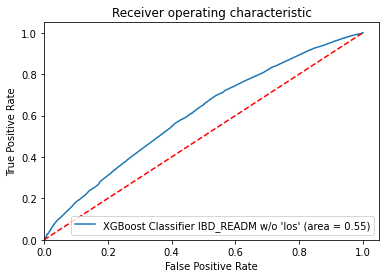

In [132]:
# Plotting the chart
plt.figure()
plt.plot(fpr, tpr, label="XGBoost Classifier IBD_READM w/o 'los' (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('images\XGBClassifier_IBD_READM_no_los_ROC_10')
plt.show()

In [133]:
# K-Fold Validation using XGBClassifier
scores = cross_validate(model, cleaned_data_wo_outcome_df, target_srs, cv=10, scoring=('roc_auc', 'precision','recall', 'accuracy'), return_train_score=True)
scores_df = pd.DataFrame(scores)
scores_df

fit_time  score_time  test_roc_auc  train_roc_auc  test_precision  \
0  0.794174    0.024878      0.604191       0.630258        0.540569   
1  0.746102    0.022844      0.610724       0.629130        0.550259   
2  0.744915    0.025884      0.615070       0.628796        0.538377   
3  0.735856    0.023632      0.617654       0.628351        0.552863   
4  0.751415    0.021957      0.598435       0.630810        0.526596   
5  0.734316    0.022661      0.599624       0.630117        0.517165   
6  0.736071    0.024086      0.603148       0.629952        0.541524   
7  0.738433    0.023811      0.616911       0.628288        0.564655   
8  0.742502    0.023832      0.601895       0.630228        0.523193   
9  0.740039    0.023915      0.607384       0.629820        0.551616   

   train_precision  test_recall  train_recall  test_accuracy  train_accuracy  
0         0.569489     0.261868      0.273630       0.602198        0.613619  
1         0.566330     0.271057      0.279984       0.606426        0.613126  
2         0.570305     0.250638      0.271531       0.600719        0.613690  
3         0.568841     0.256253      0.269091       0.606131        0.612947  
4         0.571530     0.252680      0.272892       0.596406        0.614263  
5         0.571853     0.238509      0.273160       0.592600        0.614380  
6         0.571977     0.243105      0.261928       0.601480        0.613253  
7         0.568862     0.267620      0.264084       0.611416        0.612430  
8         0.572265     0.247702      0.271799       0.595137        0.614380  
9         0.571464     0.270174      0.265161       0.606977        0.613417

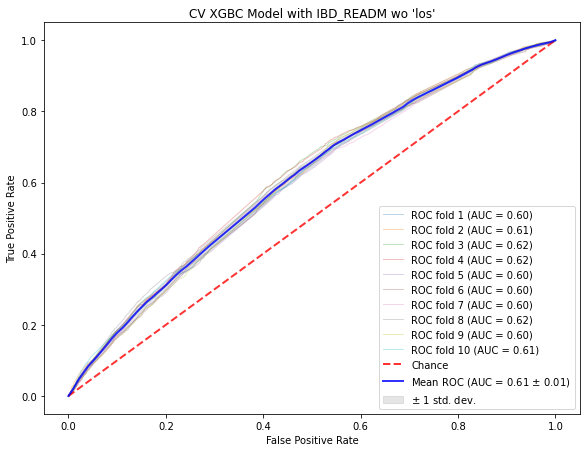

In [134]:
# Cross validated ROC/AUC chart
# Run classifier with cross-validation and plot ROC curves
draw_cv_auc_roc(model, cv, cleaned_data_wo_outcome_df, target_srs, "CV XGBC Model with IBD_READM wo 'los'")

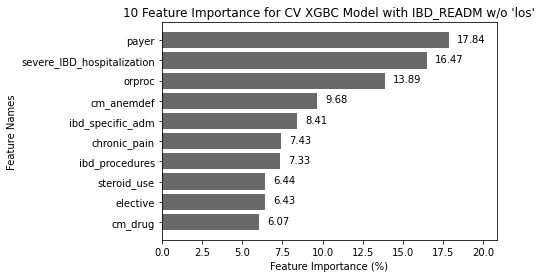

In [137]:
# Grab the feature importance using the cross validation XGBClassifier model
importance = sorted(zip(model.feature_importances_*100, X_train))

# Graph feature importance for XGBClassifier
value_labels = [x[0] for x in importance]
feature_names = [y[1] for y in importance]
fig, ax = plt.subplots()
ax.autoscale(enable=True) 
plt.barh(feature_names, value_labels, color='dimgray')
for index, value in enumerate(value_labels):
    plt.text(value/value_labels[index]+value-0.5, index-0.09, str(f'{value:.2f}'), color='black')
plt.xlabel('Feature Importance (%)')
plt.xlim((0, max(value_labels)+3))
plt.ylabel('Feature Names')
plt.title("10 Feature Importance for CV XGBC Model with IBD_READM w/o 'los'")
plt.savefig('images\XGBClassifier_IBD_READM_no_los_Feature_Importance_10')
plt.show()